# Introduction
This notebook compares the baseline model and the Hybrid LSTM-Prophet models performance to predict total daily energy demand in Saskatchewan. Each model is trained and tested using cross-validation. The models’ performances are evaluated using metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Median Absolute Percentage Error (MdAPE), and R-squared and the results are stored for each fold in the cross-validation. Finally, the performance of all models are compared, conclusions are drawn based on the evaluation metrics, and the best model is utilize for predictions using the testing dataset.

# Load Data
Forecasting daily natural gas consumption accurately is difficult because it is affected by various factors. The dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023. This dataset has be preprocessed and explored in the "cleaning_EDA.ipynb" notebook and is fit for model development. 

In [1]:
# Importing the necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for modules
from prophet import Prophet
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch, Objective

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


# Data Preparation for Modelling 

For this step, we are preparing the series for Cross-validation evaluation and the Train-test Split method.

- Train-test Split method: This method involves splitting the dataset into a training set and a testing set. The model is trained on the training set and then tested on the testing set to evaluate its performance.

- 
Cross-Validation: Cross-validation is a technique used to evaluate the performance of a machine learning model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds

In [3]:
# Split the data into learning set from 2013-11-01 to 2022-04-31, and using 2022-05-01 to 2023-10-31 as testing set
learning_data_df = merged_df[merged_df['DATE'] < '2022-05-01'] # train/validation set
testing_data_df = merged_df[merged_df['DATE'] >= '2022-05-01'] # testing set

# Print the shape of the train-test split
print(learning_data_df.shape)
print(testing_data_df.shape)

(3103, 12)
(549, 12)


# Model Building
In this project, the recommended models to be utilized are Prophet, LightGBM, SARIMAX, LSTM, Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM.

## 1. Baseline Model
In every modeling process, there needs to be a baseline model whose results can be used to assess our primary ones. In our case, we chose to use a Linear Regression model because of its simplicity and efficiency.

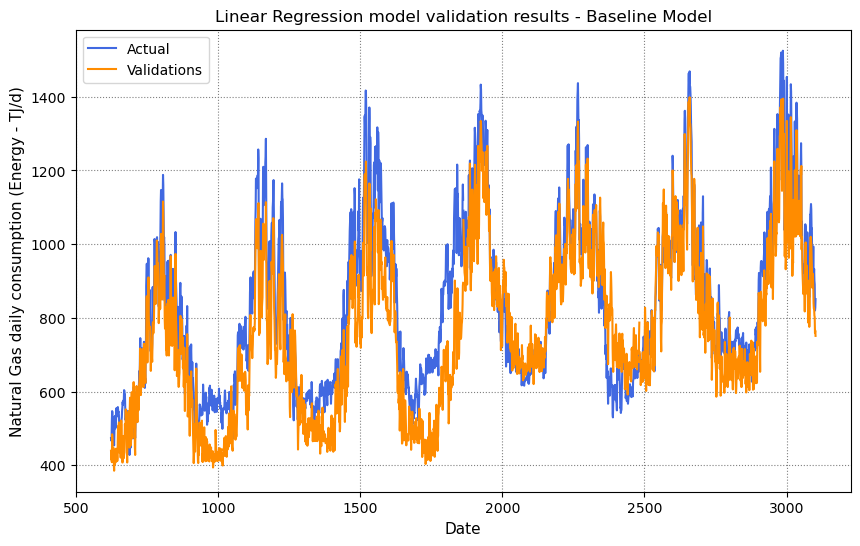


Average Validation Metrics across all Folds:
Mean Squared Error: 12113.538
Mean Absolute Error: 90.061
Root Mean Squared Error: 104.681
Mean Absolute Percentage Error: 11.254%
Median Absolute Percentage Error: 10.350%
R-squared: 0.732


In [4]:
# Split the learning dataset to training and validation sets
learning_df = learning_data_df.copy()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)  # You can adjust the number of splits

# Create a function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    mdape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)

    return mse, mae, rmse, mape, mdape, r2

# Create a Linear Regression object
lr = LinearRegression()

# Use the learning_df for training and testing
X = learning_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y = learning_df['NG_DEMAND']

base_metrics = []
plt.figure(figsize=(10, 6))

# Apply Time Series Cross-Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    lr.fit(X_train, y_train)

    # Make predictions on the test set
    validations = lr.predict(X_test)

    # Calculate the mean squared error of the predictions
    mse, mae, rmse, mape, mdape, r2 = calculate_metrics(y_test, validations)
    base_metrics.append((mse, mae, rmse, mape, mdape, r2))

    # Convert the Date to datetime
    learning_df['DATE'] = pd.to_datetime(learning_df['DATE'])

    # Plot actual vs. forecast values
    plt.plot(X_test.index, y_test, label='Actual', color='royalblue')
    plt.plot(X_test.index, validations, label='Validations', color='darkorange')
    
plt.title('Linear Regression model validation results - Baseline Model', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=11)
# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

avg_baseline_metrics = np.mean(base_metrics, axis=0)
print("\nAverage Validation Metrics across all Folds:")
print(f"Mean Squared Error: {avg_baseline_metrics[0]:.3f}")
print(f"Mean Absolute Error: {avg_baseline_metrics[1]:.3f}")
print(f"Root Mean Squared Error: {avg_baseline_metrics[2]:.3f}")
print(f"Mean Absolute Percentage Error: {avg_baseline_metrics[3]:.3f}%")
print(f"Median Absolute Percentage Error: {avg_baseline_metrics[4]:.3f}%")
print(f"R-squared: {avg_baseline_metrics[5]:.3f}")

## Prophet and LSTM Hybrid Model
The hybrid model combines the strengths of Prophet and LSTM to improve the accuracy and robustness of time series forecasting of Natural Gas consumption. The workflow involves using Prophet to generate initial predictions and then using these predictions as input to train an LSTM model. The LSTM model learns from the residuals (the differences between the actual values and the Prophet predictions) and generates refined forecasts.

The hybrid model can be summarized in the following steps:
- Use Prophet to fit a time series and generate initial predictions.
- Calculate the residuals by subtracting the Prophet forecasts from the actual values.
- Train an LSTM model using the residuals as input.
- Generate refined forecasts by combining the Prophet predictions and the LSTM predictions.

By combining the strengths of both models, the hybrid model can capture both the global trends and the local patterns in the time series data, resulting in more accurate and reliable forecasts.

00:12:30 - cmdstanpy - INFO - Chain [1] start processing
00:12:30 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 6ms/step
Fold Metrics - MSE: 210.170, MAE: 10.772, RMSE: 14.497, MAPE: 1.606%, MdAPE: 1.111%, R-squared: 0.994


00:12:50 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 5ms/step
Fold Metrics - MSE: 203.213, MAE: 9.011, RMSE: 14.255, MAPE: 1.172%, MdAPE: 0.927%, R-squared: 0.996


00:13:11 - cmdstanpy - INFO - Chain [1] start processing
00:13:13 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 2s 7ms/step
Fold Metrics - MSE: 152.180, MAE: 8.486, RMSE: 12.336, MAPE: 1.055%, MdAPE: 0.591%, R-squared: 0.997


00:13:33 - cmdstanpy - INFO - Chain [1] start processing
00:13:36 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 5ms/step
Fold Metrics - MSE: 212.888, MAE: 10.421, RMSE: 14.591, MAPE: 1.079%, MdAPE: 0.782%, R-squared: 0.995


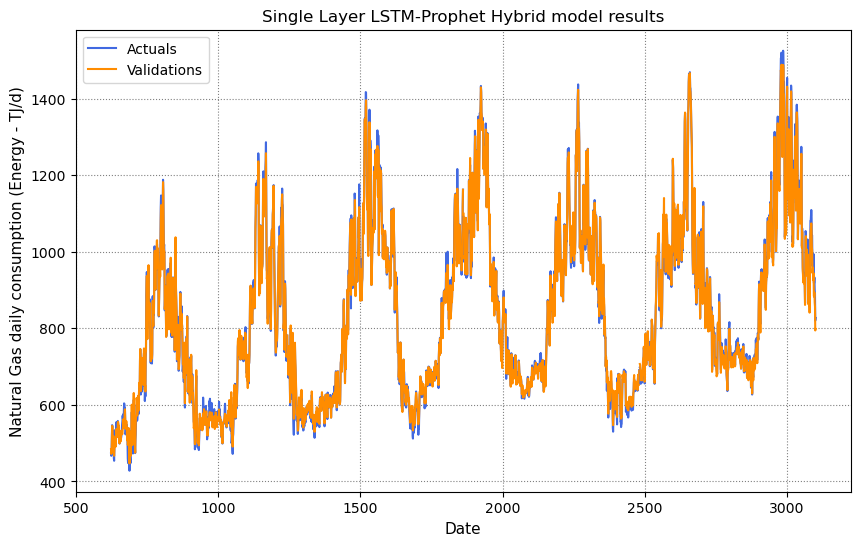


Average Prediction Metrics across Folds:
Mean Squared Error: 194.613
Mean Absolute Error: 9.673
Root Mean Squared Error: 13.920
Mean Absolute Percentage Error: 1.228%
Median Absolute Percentage Error: 0.853%
R-squared: 0.996


In [5]:
# Prepare your data
df = learning_data_df.copy()
df = df.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['y', 'ds']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['y']])

df_scaled = pd.concat([df[['ds', 'y']], pd.DataFrame(scaled_X, columns=df.columns.drop(['y', 'ds']))], axis=1)

# Define your additional regressors
additional_regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
                         'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
                         'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Add dropout with rate 0.2
    model.add(LSTM(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Add dropout with rate 0.2
    model.add(Dense(1))  # You can adjust the number of output units based on your problem
    model.compile(optimizer='adam', loss='mean_squared_error') 
    return model

# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    # Calculate various performance metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    r_squared = r2_score(y_true, y_pred)
    
    return mse, mae, rmse, mape, mdape, r_squared
    
# Split your data into training and testing sets
tscv = TimeSeriesSplit(n_splits=4)

all_hybrid_metrics =[]
plt.figure(figsize=(10,6))

# Train your hybrid model with cross-validation
for train_index, test_index in tscv.split(df_scaled):
    train, test = df_scaled.iloc[train_index], df_scaled.iloc[test_index]

    prophet_model = Prophet()
    for regressor in additional_regressors:
        prophet_model.add_regressor(regressor)
    prophet_model.fit(train)
    prophet_predictions = prophet_model.predict(test)
    residuals = test['y'].values - prophet_predictions['yhat'].values

    # Save the Prophet model
    with open('../models/lstm_prophet_model.pkl', 'wb') as model_file:
        pickle.dump(prophet_model, model_file)

    # Create your LSTM model
    model = create_lstm_model(input_shape=(None, 1))
    
    # Train the LSTM model
    model.fit(residuals[:-1].reshape(-1, 1, 1), residuals[1:], epochs=50, batch_size=32, verbose=0)
    
    # Save the LSTM model
    model.save('../models/lstm_hybrid_model.h5')

    # Make predictions
    lstm_predictions = model.predict(residuals[:-1].reshape(-1, 1, 1)).flatten()

    hybrid_predictions = prophet_predictions['yhat'].values[:-1] + lstm_predictions

    # Calculate the performance metrics
    mse, mae, rmse, mape, mdape, r_squared = calculate_metrics(test['y'].values[:-1], hybrid_predictions)
    all_hybrid_metrics.append([mse, mae, rmse, mape, mdape, r_squared])

    # Print the performance metrics for this fold
    print(f"Fold Metrics - MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r_squared:.3f}")

    # Plot actuals vs. forecasts for this fold
    plt.plot(df.iloc[test_index].index[:-1], test['y'].values[:-1], color='royalblue', label='Actuals')
    plt.plot(df.iloc[test_index].index[:-1], hybrid_predictions, color='darkorange', label='Validations')

# Set the title for the plot
plt.title('Single Layer LSTM-Prophet Hybrid model results', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=11)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate and print the average metrics across folds
avg_metrics = np.mean(all_hybrid_metrics, axis=0)   
print("\nAverage Prediction Metrics across Folds:")
print(f"Mean Squared Error: {avg_metrics[0]:.3f}")
print(f"Mean Absolute Error: {avg_metrics[1]:.3f}")
print(f"Root Mean Squared Error: {avg_metrics[2]:.3f}")
print(f"Mean Absolute Percentage Error: {avg_metrics[3]:.3f}%")
print(f"Median Absolute Percentage Error: {avg_metrics[4]:.3f}%")
print(f"R-squared: {avg_metrics[5]:.3f}")

## Hyperparameter turning

Trial 5 Complete [00h 02m 24s]
val_mean_absolute_error: 21.89938735961914

Best val_mean_absolute_error So Far: 21.830233256022137
Total elapsed time: 00h 09m 08s
20/20 [==============================] - 2s 12ms/step
Fold Metrics - MSE: 234.599, MAE: 12.017, RMSE: 15.317, MAPE: 1.759%, MdAPE: 1.389%, R-squared: 0.994


00:24:27 - cmdstanpy - INFO - Chain [1] start processing
00:24:28 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 11ms/step
Fold Metrics - MSE: 205.456, MAE: 8.571, RMSE: 14.334, MAPE: 1.082%, MdAPE: 0.841%, R-squared: 0.996


00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:07 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 10ms/step
Fold Metrics - MSE: 179.540, MAE: 9.649, RMSE: 13.399, MAPE: 1.221%, MdAPE: 0.828%, R-squared: 0.996


00:25:46 - cmdstanpy - INFO - Chain [1] start processing
00:25:49 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 2s 18ms/step
Fold Metrics - MSE: 94.779, MAE: 7.308, RMSE: 9.735, MAPE: 0.789%, MdAPE: 0.678%, R-squared: 0.998


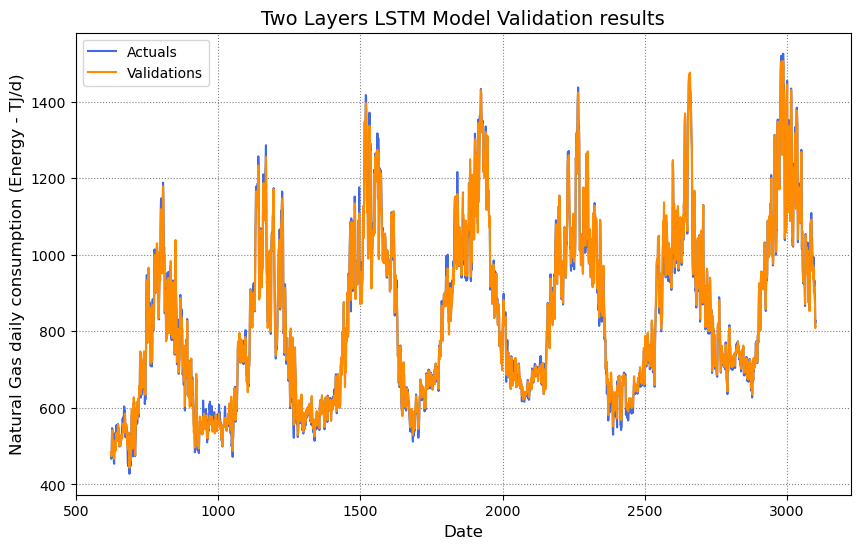


Average Validation Metrics across Folds:
Mean Squared Error: 178.594
Mean Absolute Error: 9.386
Root Mean Squared Error: 13.196
Mean Absolute Percentage Error: 1.213%
Median Absolute Percentage Error: 0.934%
R-squared: 0.996


In [6]:
# Prepare your data
df = learning_data_df.copy()
df = df.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['y', 'ds']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['y']])

df_scaled = pd.concat([df[['ds', 'y']], pd.DataFrame(scaled_X, columns=df.columns.drop(['y', 'ds']))], axis=1)

# Define your additional regressors
additional_regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
                         'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
                         'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    # Calculate various performance metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    r_squared = r2_score(y_true, y_pred)
    
    return mse, mae, rmse, mape, mdape, r_squared

# Function to create LSTM model with tunable hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   activation='relu', return_sequences=True, input_shape=(None, 1),
                   kernel_regularizer=l2(0.01)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']), 
              loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective=Objective('val_mean_absolute_error', direction='min'),  # set the objective to minimize mean absolute error
    max_trials=5,  # number of model configurations to test
    executions_per_trial=3,  # number of trials per configuration
    directory='my_dir',
    project_name='lstm_tuning')

# Split your data into training and testing sets
tscv = TimeSeriesSplit(n_splits=4)

opt_hybrid_metrics =[]
plt.figure(figsize=(10,6))

# Train your hybrid model with cross-validation
for train_index, test_index in tscv.split(df_scaled):
    train, test = df_scaled.iloc[train_index], df_scaled.iloc[test_index]

    prophet_model = Prophet()
    for regressor in additional_regressors:
        prophet_model.add_regressor(regressor)
    prophet_model.fit(train)
    prophet_predictions = prophet_model.predict(test)
    residuals = test['y'].values - prophet_predictions['yhat'].values

    # Save the Prophet model
    with open('../models/optimized_lstm_prophet_model.pkl', 'wb') as model_file:
        pickle.dump(prophet_model, model_file)
        
    # Perform hyperparameter search
    tuner.search(residuals[:-1].reshape(-1, 1, 1), residuals[1:], epochs=50, validation_split=0.2)
    
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Build the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hps)
    
    # Train the LSTM model
    model.fit(residuals[:-1].reshape(-1, 1, 1), residuals[1:], epochs=50, batch_size=32, verbose=0)

    # Save the LSTM model
    model.save('../models/optimized_lstm_hybrid_model.h5')

    # Make predictions
    lstm_predictions = model.predict(residuals[:-1].reshape(-1, 1, 1)).flatten()

    hybrid_predictions = prophet_predictions['yhat'].values[:-1] + lstm_predictions

    # Calculate the performance metrics
    mse, mae, rmse, mape, mdape, r_squared = calculate_metrics(test['y'].values[:-1], hybrid_predictions)
    opt_hybrid_metrics.append([mse, mae, rmse, mape, mdape, r_squared])

    # Print the performance metrics for this fold
    print(f"Fold Metrics - MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r_squared:.3f}")

    # Plot actuals vs. forecasts for this fold
    plt.plot(df.iloc[test_index].index[:-1], test['y'].values[:-1], color='royalblue', label='Actuals')
    plt.plot(df.iloc[test_index].index[:-1], hybrid_predictions, color='darkorange', label='Validations')

# Set the title for the plot
plt.title('Two Layers LSTM Model Validation results', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=12)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate and print the average metrics across folds
avg_optimized_metrics = np.mean(opt_hybrid_metrics, axis=0)   
print("\nAverage Validation Metrics across Folds:")
print(f"Mean Squared Error: {avg_optimized_metrics[0]:.3f}")
print(f"Mean Absolute Error: {avg_optimized_metrics[1]:.3f}")
print(f"Root Mean Squared Error: {avg_optimized_metrics[2]:.3f}")
print(f"Mean Absolute Percentage Error: {avg_optimized_metrics[3]:.3f}%")
print(f"Median Absolute Percentage Error: {avg_optimized_metrics[4]:.3f}%")
print(f"R-squared: {avg_optimized_metrics[5]:.3f}")

In [11]:
# Accessing individual metrics for Baseline model with cross-validation 
mse_baseline_cv = avg_baseline_metrics[0]
mae_baseline_cv= avg_baseline_metrics[1]
rmse_baseline_cv = avg_baseline_metrics[2]
mape_baseline_cv = avg_baseline_metrics[3]
mdape_baseline_cv = avg_baseline_metrics[4]
r2_baseline_cv = avg_baseline_metrics[5]

# Access individual metrics from the optimized hybrid model validation (LSTM-Prophet hybrid model)
mse_lstm_ph = avg_metrics[0]
mae_lstm_ph = avg_metrics[1]
rmse_lstm_ph = avg_metrics[2]
mape_lstm_ph = avg_metrics[3]
mdape_lstm_ph = avg_metrics[4]
r2_lstm_ph = avg_metrics[5]

# Access individual metrics from the optimized hybrid model validation (LSTM-Prophet hybrid model)
mse_lstm_ph2 = avg_optimized_metrics[0]
mae_lstm_ph2 = avg_optimized_metrics[1]
rmse_lstm_ph2 =avg_optimized_metrics[2]
mape_lstm_ph2 = avg_optimized_metrics[3]
mdape_lstm_ph2 = avg_optimized_metrics[4]
r2_lstm_ph2 = avg_optimized_metrics[5]

metrics_base_model = [mse_baseline_cv, mae_baseline_cv, rmse_baseline_cv, mape_baseline_cv, mdape_baseline_cv, r2_baseline_cv]
metrics_lstm_ph = [mse_lstm_ph, rmse_lstm_ph, mape_lstm_ph, mae_lstm_ph, mdape_lstm_ph, r2_lstm_ph]
metrics_optimized_lstm_ph = [mse_lstm_ph2, rmse_lstm_ph2, mape_lstm_ph2, mae_lstm_ph2, mdape_lstm_ph2, r2_lstm_ph2]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_lstm_prophet_metrics = pd.DataFrame({'Baseline Model': metrics_base_model, 'LSTM-Prophet hybrid model': metrics_lstm_ph, 
                                        'Optimized LSTM-Prophet hybrid model': metrics_optimized_lstm_ph}, index=labels)

# Transpose the DataFrame
df_lstm_prophet_metrics = df_lstm_prophet_metrics.transpose()                                       

df_lstm_prophet_metrics  = df_lstm_prophet_metrics.applymap(lambda x: f'{x: .3f}')
df_lstm_prophet_metrics.head(10)

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Baseline Model,12113.538,90.061,104.681,11.254,10.350,0.732
LSTM-Prophet hybrid model,194.613,13.920,1.228,9.673,0.853,0.996
Optimized LSTM-Prophet hybrid model,178.594,13.196,1.213,9.386,0.934,0.996


In summary, the Optimized LSTM-Prophet Hybrid model performs the best in terms of all the metrics used for evaluation. It has the lowest MSE, RMSE, MAPE, MAE, and MDAPE, and the highest R-squared value, indicating the best fit to the data. The other models also show improvements over the baseline model, but not as much as the Optimized LSTM-Prophet Hybrid model.

## LSTM-Prophet Model Testing Performance

**1. Hybrid model with Cross-validation**

18/18 [==============================] - 1s 8ms/step

Prediction Hybrid Performance Metrics for the Testing Dataset:
Test Mean Squared Error: 2677.447
Test Mean Absolute Error: 44.564
Test Root Mean Squared Error: 51.744
Test Mean Absolute Percentage Error: 5.058%
Test Median Absolute Percentage Error: 4.142%
Test R-squared: 0.936

Prediction Optimized Hybrid Performance Metrics for the Testing Dataset:
Test Mean Squared Error: 653.939
Test Mean Absolute Error: 21.889
Test Root Mean Squared Error: 25.572
Test Mean Absolute Percentage Error: 2.486%
Test Median Absolute Percentage Error: 2.101%
Test R-squared: 0.984


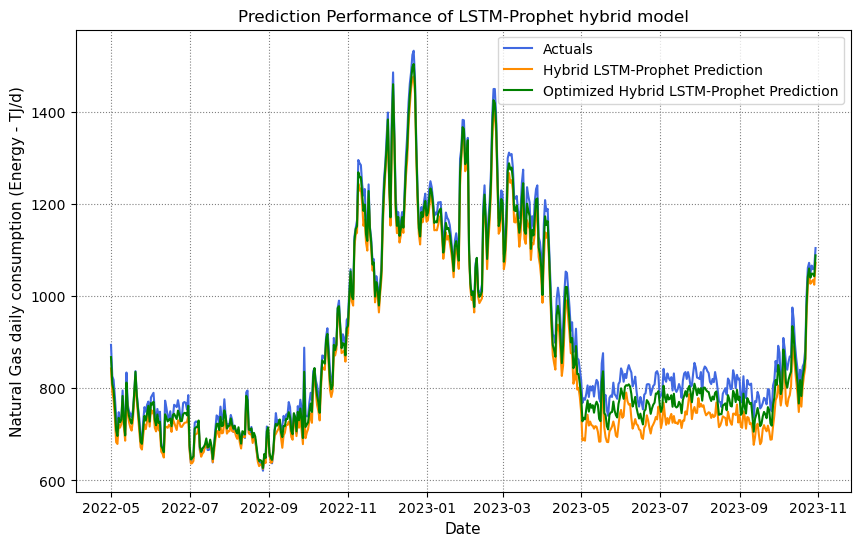

In [9]:
# Load the saved Prophet model
with open('../models/lstm_prophet_model.pkl', 'rb') as model_file:
    loaded_prophet_model = pickle.load(model_file)

# Load the saved Optimized Prophet model
with open('../models/optimized_lstm_prophet_model.pkl', 'rb') as model_file:
    loaded_optimized_prophet_model = pickle.load(model_file)

# Load the saved LSTM model
loaded_lstm_model = load_model('../models/lstm_hybrid_model.h5')

# Load the saved optimized LSTM model
loaded_optimized_lstm_model = load_model('../models/optimized_lstm_hybrid_model.h5')

# Now you can use the loaded models to make predictions on new data
# Prepare your new data for prediction (similar preprocessing as before)
testing_df = testing_data_df.copy()  # Load or prepare your new data here
testing_df = testing_df.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(testing_df.drop(columns=['y', 'ds']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(testing_df[['y']])

testing_df_subset = testing_df[['ds', 'y']].reset_index(drop=True)
scaled_X_df = pd.DataFrame(scaled_X, columns=testing_df.columns.drop(['y', 'ds'])).reset_index(drop=True)
testing_df_scaled = pd.concat([testing_df_subset, scaled_X_df], axis=1)   

# Define your additional regressors
additional_regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
                         'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
                         'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# For Prophet model prediction
prophet_test_predictions = loaded_prophet_model.predict(testing_df_scaled)
prophet_test2_predictions = loaded_optimized_prophet_model.predict(testing_df_scaled)

# For LSTM model prediction (assuming 'residuals' are computed similar to the previous code)
test_residuals = testing_df_scaled['y'].values - prophet_test_predictions['yhat'].values    # Compute residuals for new data
test2_residuals = testing_df_scaled['y'].values - prophet_test2_predictions['yhat'].values    # Compute residuals for new data

lstm_test_predictions = loaded_lstm_model.predict(test_residuals[:-1].reshape(-1, 1, 1)).flatten()
lstm_test2_predictions = loaded_optimized_lstm_model.predict(test2_residuals[:-1].reshape(-1, 1, 1)).flatten()

# Combine predictions (hybrid) or use them separately based on your requirements
hybrid_test_predictions = prophet_test_predictions['yhat'].values[:-1] + lstm_test_predictions
hybrid_test2_predictions = prophet_test2_predictions['yhat'].values[:-1] + lstm_test2_predictions

# Create a dataframe that contains actuals and predictions
hybrid_results_df = pd.DataFrame()
hybrid_results_df['ds'] = testing_df_scaled['ds'].values[:-1]
hybrid_results_df['y'] = testing_df_scaled['y'].values[:-1]
hybrid_results_df['Predicted_y'] = hybrid_test_predictions
hybrid_results_df['Optimized_Predicted_y'] = hybrid_test2_predictions

# Calculate performance metrics for the test set
test_mse, test_mae, test_rmse, test_mape, test_mdape, test_r_squared = calculate_metrics(hybrid_results_df['y'], hybrid_results_df['Predicted_y'])
test2_mse, test2_mae, test2_rmse, test2_mape, test2_mdape, test2_r_squared = calculate_metrics(hybrid_results_df['y'], hybrid_results_df['Optimized_Predicted_y'])

# Print hybrid prediction performance metrics
print("\nPrediction Hybrid Performance Metrics for the Testing Dataset:")
print(f'Test Mean Squared Error: {test_mse:.3f}')
print(f'Test Mean Absolute Error: {test_mae:.3f}')
print(f'Test Root Mean Squared Error: {test_rmse:.3f}')
print(f'Test Mean Absolute Percentage Error: {test_mape:.3f}%')
print(f'Test Median Absolute Percentage Error: {test_mdape:.3f}%')
print(f'Test R-squared: {test_r_squared:.3f}')

# Print optimized hybrid prediction performance metrics
print("\nPrediction Optimized Hybrid Performance Metrics for the Testing Dataset:")
print(f'Test Mean Squared Error: {test2_mse:.3f}')
print(f'Test Mean Absolute Error: {test2_mae:.3f}')
print(f'Test Root Mean Squared Error: {test2_rmse:.3f}')
print(f'Test Mean Absolute Percentage Error: {test2_mape:.3f}%')
print(f'Test Median Absolute Percentage Error: {test2_mdape:.3f}%')
print(f'Test R-squared: {test2_r_squared:.3f}')

# Convert date to Datatime
hybrid_results_df['ds'] = pd.to_datetime(hybrid_results_df['ds'])

# Plot actuals vs. forecasts for this fold
plt.figure(figsize=(10, 6))
plt.plot(hybrid_results_df['ds'], hybrid_results_df['y'], color='royalblue', label='Actuals')
plt.plot(hybrid_results_df['ds'], hybrid_results_df['Predicted_y'], color='darkorange', label='Hybrid LSTM-Prophet Prediction')
plt.plot(hybrid_results_df['ds'], hybrid_results_df['Optimized_Predicted_y'], color='green', label='Optimized Hybrid LSTM-Prophet Prediction')
plt.title('Prediction Performance of LSTM-Prophet hybrid model', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=11)
plt.legend()
plt.grid(linestyle=":", color='grey')
plt.show()

In [10]:
# Save the prediction result dataframe
hybrid_results_df.to_csv('../data/hybrid_prediction.csv', index=False)
hybrid_results_df.head()

,ds,y,Predicted_y,Optimized_Predicted_y
0,2022-05-01,894,842.833315,867.413042
1,2022-05-02,826,791.773494,808.845179
2,2022-05-03,818,775.120489,795.785330
3,2022-05-04,782,737.149591,758.707437
4,2022-05-05,737,682.761460,708.890626


In [25]:
# Define the metrics for the predicted model
lstm_prophet_prediction_metrics = [test2_mse, test2_mae, test2_rmse, test2_mape, test2_mdape, test2_r_squared]

# Define the labels for the metrics
labels = ['MSE', 'MAE', 'RMSE', 'MAPE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_lstm_prophet__pred = pd.DataFrame({'Optimized LSTM-Prophet Model Prediction': lstm_prophet_prediction_metrics}, index=labels)

# Transpose the DataFrame
df_lstm_prophet__pred = df_lstm_prophet__pred.transpose()

# Save the DataFrame to a CSV file
df_lstm_prophet__pred.to_csv('../data/hybrid_predictions_metrics.csv', index=False)
df_lstm_prophet__pred.head(10)

,MSE,MAE,RMSE,MAPE,MDAPE,R-squared
Optimized LSTM-Prophet Model Prediction,2638.454094,44.810526,51.365885,5.074441,4.367038,0.937336


# 
From these metrics, we can see that the Optimized LSTM-Prophet model performs significantly better than the LSTM-Prophet model on the testing dataset. It has a lower MSE, MAE, RMSE, MAPE, and MDAPE, and a higher R-squared value, indicating a better fit to the data and lower prediction errors. The improvements in the error metrics suggest that the optimizations made to the Hybrid model were effective in enhancing its predictive performance. The R-squared value of 0.984 for the Optimized Hybrid model indicates that it explains 98.4% of the variance in the target variable, which is an excellent result. Overall, the Optimized Hybrid model demonstrates strong performance and would likely be the preferred model for future predictions.